# All-pole model prior $p(x,y)$

## Model

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this.

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

The coefficients are given by "the excluded pole product":

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p) = {G \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

where the gain $G = \prod_{k=1}^K |p_k|^2$ and $\tilde{h}(x; p)$ is defined below.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

Transfer function: (Fourier transform of $h(t; p)$ with our convention)

$$ \tilde{h}(x; p) = {G \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

Note that the overall scale is determined by the DGF, so we normalize such that $h(0, p) = 1$.



## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.) Consequently, the spectral rolloff at a given point is also determined by all poles jointly.

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

### PZ-model

The above paragraph assumed an AP (all-pole) model. But we could also contemplate a PZ (pole-zero) model where the amplitudes *are* free parameters (equivalent to introducing zeros, but easier because we can get a better prior and we don't have to calculate the partial fraction expansion and we have nested models for $A_k=0$).

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-11-15 20:22:32.490947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]7.3s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]40.1s, 0.7min   : Loading run_nested...
[Memory]44.6s, 0.7min   : Loading run_nested...
[Memory]48.8s, 0.8min   : Loading run_nested...
[Memory]53.0s, 0.9min   : Loading run_nested...
[Memory]53.0s, 0.9min   : Loading get_aplawd_training_pairs...


[Memory]63.2s, 1.1min   : Loading get_vtrformants_training_data...
[Memory]81.4s, 1.4min   : Loading run_nested...
[Memory]84.0s, 1.4min   : Loading run_nested...
[Memory]86.5s, 1.4min   : Loading run_nested...
[Memory]89.0s, 1.5min   : Loading run_nested...
[Memory]89.0s, 1.5min   : Loading get_vtrformants_training_data...


## Check AP power spectrum

In [2]:
prior = bandwidth.TFB_prior()

[Memory]97.9s, 1.6min   : Loading get_vtrformants_training_data...
[Memory]99.9s, 1.7min   : Loading run_nested...
[Memory]103.9s, 1.7min  : Loading run_nested...


[ 626.15823474 1507.89469874 2229.757508  ]
[ 39.70041938  98.75131847 184.5938556 ]


/home/marnix/WRK/thesis/py/vtr/spectrum.py:109: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


(-22.16018921955309, -36.12359947967774)

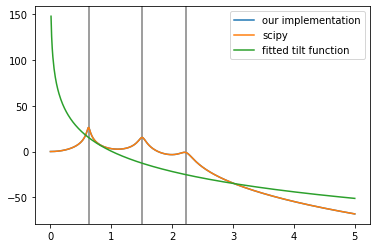

In [15]:
T, *xy = prior.sample(seed=jaxkey())
xy = np.array(xy)
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = np.linspace(0, constants.FS_KHZ/2, 500)
power = allpole.transfer_function_power_dB(f, poles)

plot(f, power, label="our implementation")
for xi in x: axvline(xi/1000, color="grey")

##
import scipy.signal

p = hstack([poles, conj(poles)])*1000
k = prod(abs(p))

w, H = scipy.signal.freqresp(([], p, k), 2*pi*f*1000)
plot(f, 20*log10(abs(H)), label="scipy")

##
tilt, interp = spectrum.fit_tilt(f*1000, power, return_interp=True)
plot(f, interp(f*1000), label="fitted tilt function")

legend()
tilt, allpole.analytical_tilt(3)

## Peak mergers in our TFB prior

About 15% of the power spectra of of samples from the TFB prior contain merged peaks (always F1 and F2).

We can apply rejection sampling to get rid of these.

CPU times: user 30.3 s, sys: 8.68 ms, total: 30.3 s
Wall time: 30.3 s


(array([ 67.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 933.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

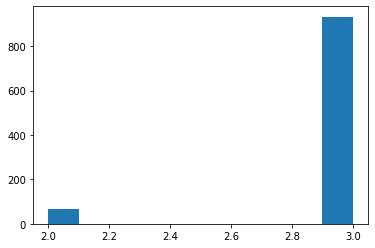

In [4]:
%%time
def sample_power_spectrum_dB(K=3, key=None):
    key = key if key is not None else jaxkey()
    f = constants.spectrum_frequencies()
    T, *xy = prior.sample(seed=key)
    xy = np.array(xy)
    x, y = np.split(xy, 2)
    x = x[:K]
    y = y[:K]
    poles = core.make_poles(y, x)
    power = allpole.transfer_function_power_dB(f/1000, poles)
    return f, x, y, power

def sample_K():
    f, x, y, power = sample_power_spectrum_dB(3, jaxkey())
    power = np.array(power)

    F, B = spectrum.get_formants_from_spectrum(
        f,
        power
    )
    
    K = len(F)
    return K

Ks = [sample_K() for _ in range(1000)]
hist(Ks)

## Try a fit

In [16]:
%%time
samples = allpole.get_TFB_samples()

[Memory]347.7s, 5.8min  : Loading get_TFB_samples...
CPU times: user 68.5 ms, sys: 24 µs, total: 68.5 ms
Wall time: 81.7 ms


In [19]:
def unpack(params):
    rho, h = params[:2]
    x, y = np.split(params[2:], 2)
    return rho, h, x, y

{'T': DeviceArray(5.30424945, dtype=float64),
 'F': array([ 506.86931989, 1463.46073199, 2809.28063731]),
 'B': array([ 54.41049371,  72.60370738, 240.57431595]),
 'f': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
        4.999e+03]),
 'power': DeviceArray([ 0.00000000e+00,  3.86601423e-05,  1.54641348e-04, ...,
              -6.68905999e+01, -6.69029836e+01, -6.69153638e+01],            dtype=float64)}

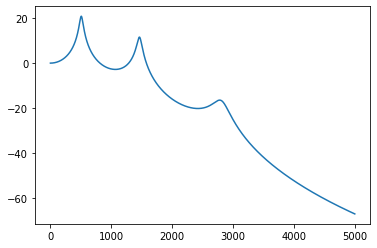

In [17]:
sample = samples[5]

plot(sample['f'], sample['power'])
sample

In [49]:
K = 5

results = allpole.fit_TFB_sample(sample, 5, 1111111)

________________________________________________________________________________
[Memory] Calling vtr.prior.allpole.run_nested...
run_nested(1111111, {'bootstrap': 10, 'nlive': 60, 'sample': 'rslice'}, {'maxcall': 300000, 'save_bounds': False})


1939it [10:26,  3.09it/s, +60 | bound: 89 | nc: 1 | ncall: 163956 | eff(%):  1.220 | loglstar:   -inf < -9.788 <    inf | logz: -39.169 +/-    nan | dlogz:  0.001 >  0.069] 

____________________________________________________run_nested - 627.0s, 10.5min


Summary
nlive: 60
niter: 1939
ncall: 163896
eff(%):  1.220
logz: -39.169 +/-  0.676


None

'Information (bans)'

10.377734214973309

Quantiles:
rho [(0.025, 0.0804225256500531), (0.5, 0.5642550947261545), (0.975, 0.9643879915889731)]
Quantiles:
h [(0.025, 1.1729416498964498), (0.5, 2.514239642773517), (0.975, 5.940005319856226)]
Quantiles:
x [(0.025, 503.4526128451208), (0.5, 506.9040559592162), (0.975, 510.48055209132417)]
Quantiles:
x [(0.025, 1452.7338179760106), (0.5, 1466.7658442768404), (0.975, 1480.718304174946)]
Quantiles:
x [(0.025, 2777.463029338238), (0.5, 2829.0486033228162), (0.975, 2881.121792529193)]
Quantiles:
x [(0.025, 3409.421207954772), (0.5, 3909.5986558855766), (0.975, 4455.282287013629)]
Quantiles:
x [(0.025, 3982.15383821175), (0.5, 4512.585348837205), (0.975, 4960.020189910941)]
Quantiles:
y [(0.025, 47.23951919809653), (0.5, 54.74675507222431), (0.975, 62.36704672866074)]
Quantiles:
y [(0.025, 47.08640930116902), (0.5, 69.90166994491118), (0.975, 97.20440161425311)]
Quantiles:
y [(0.025, 94.38757495592213), (0.5, 204.35036394700077), (0.975, 298.0370579219705)]
Quantiles:
y [(0.025, 256.272

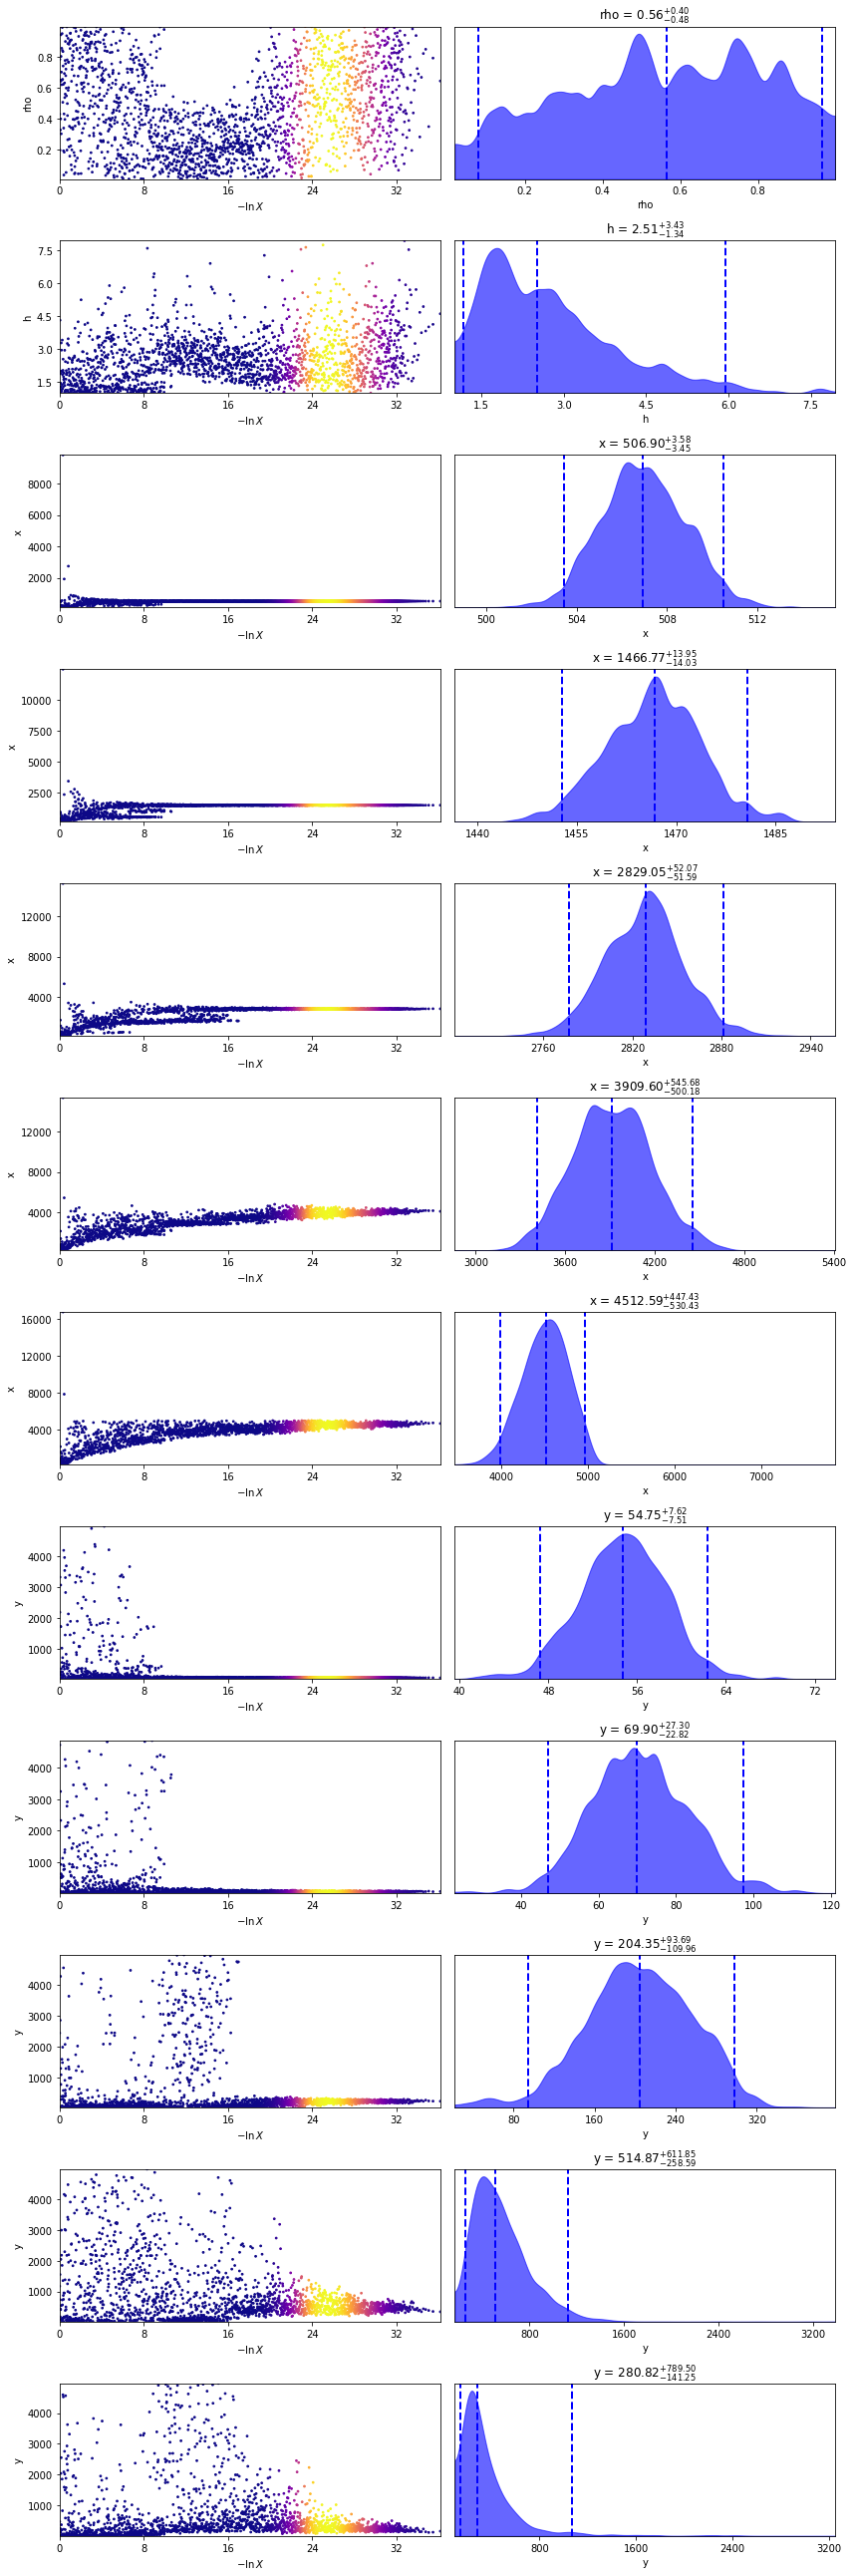

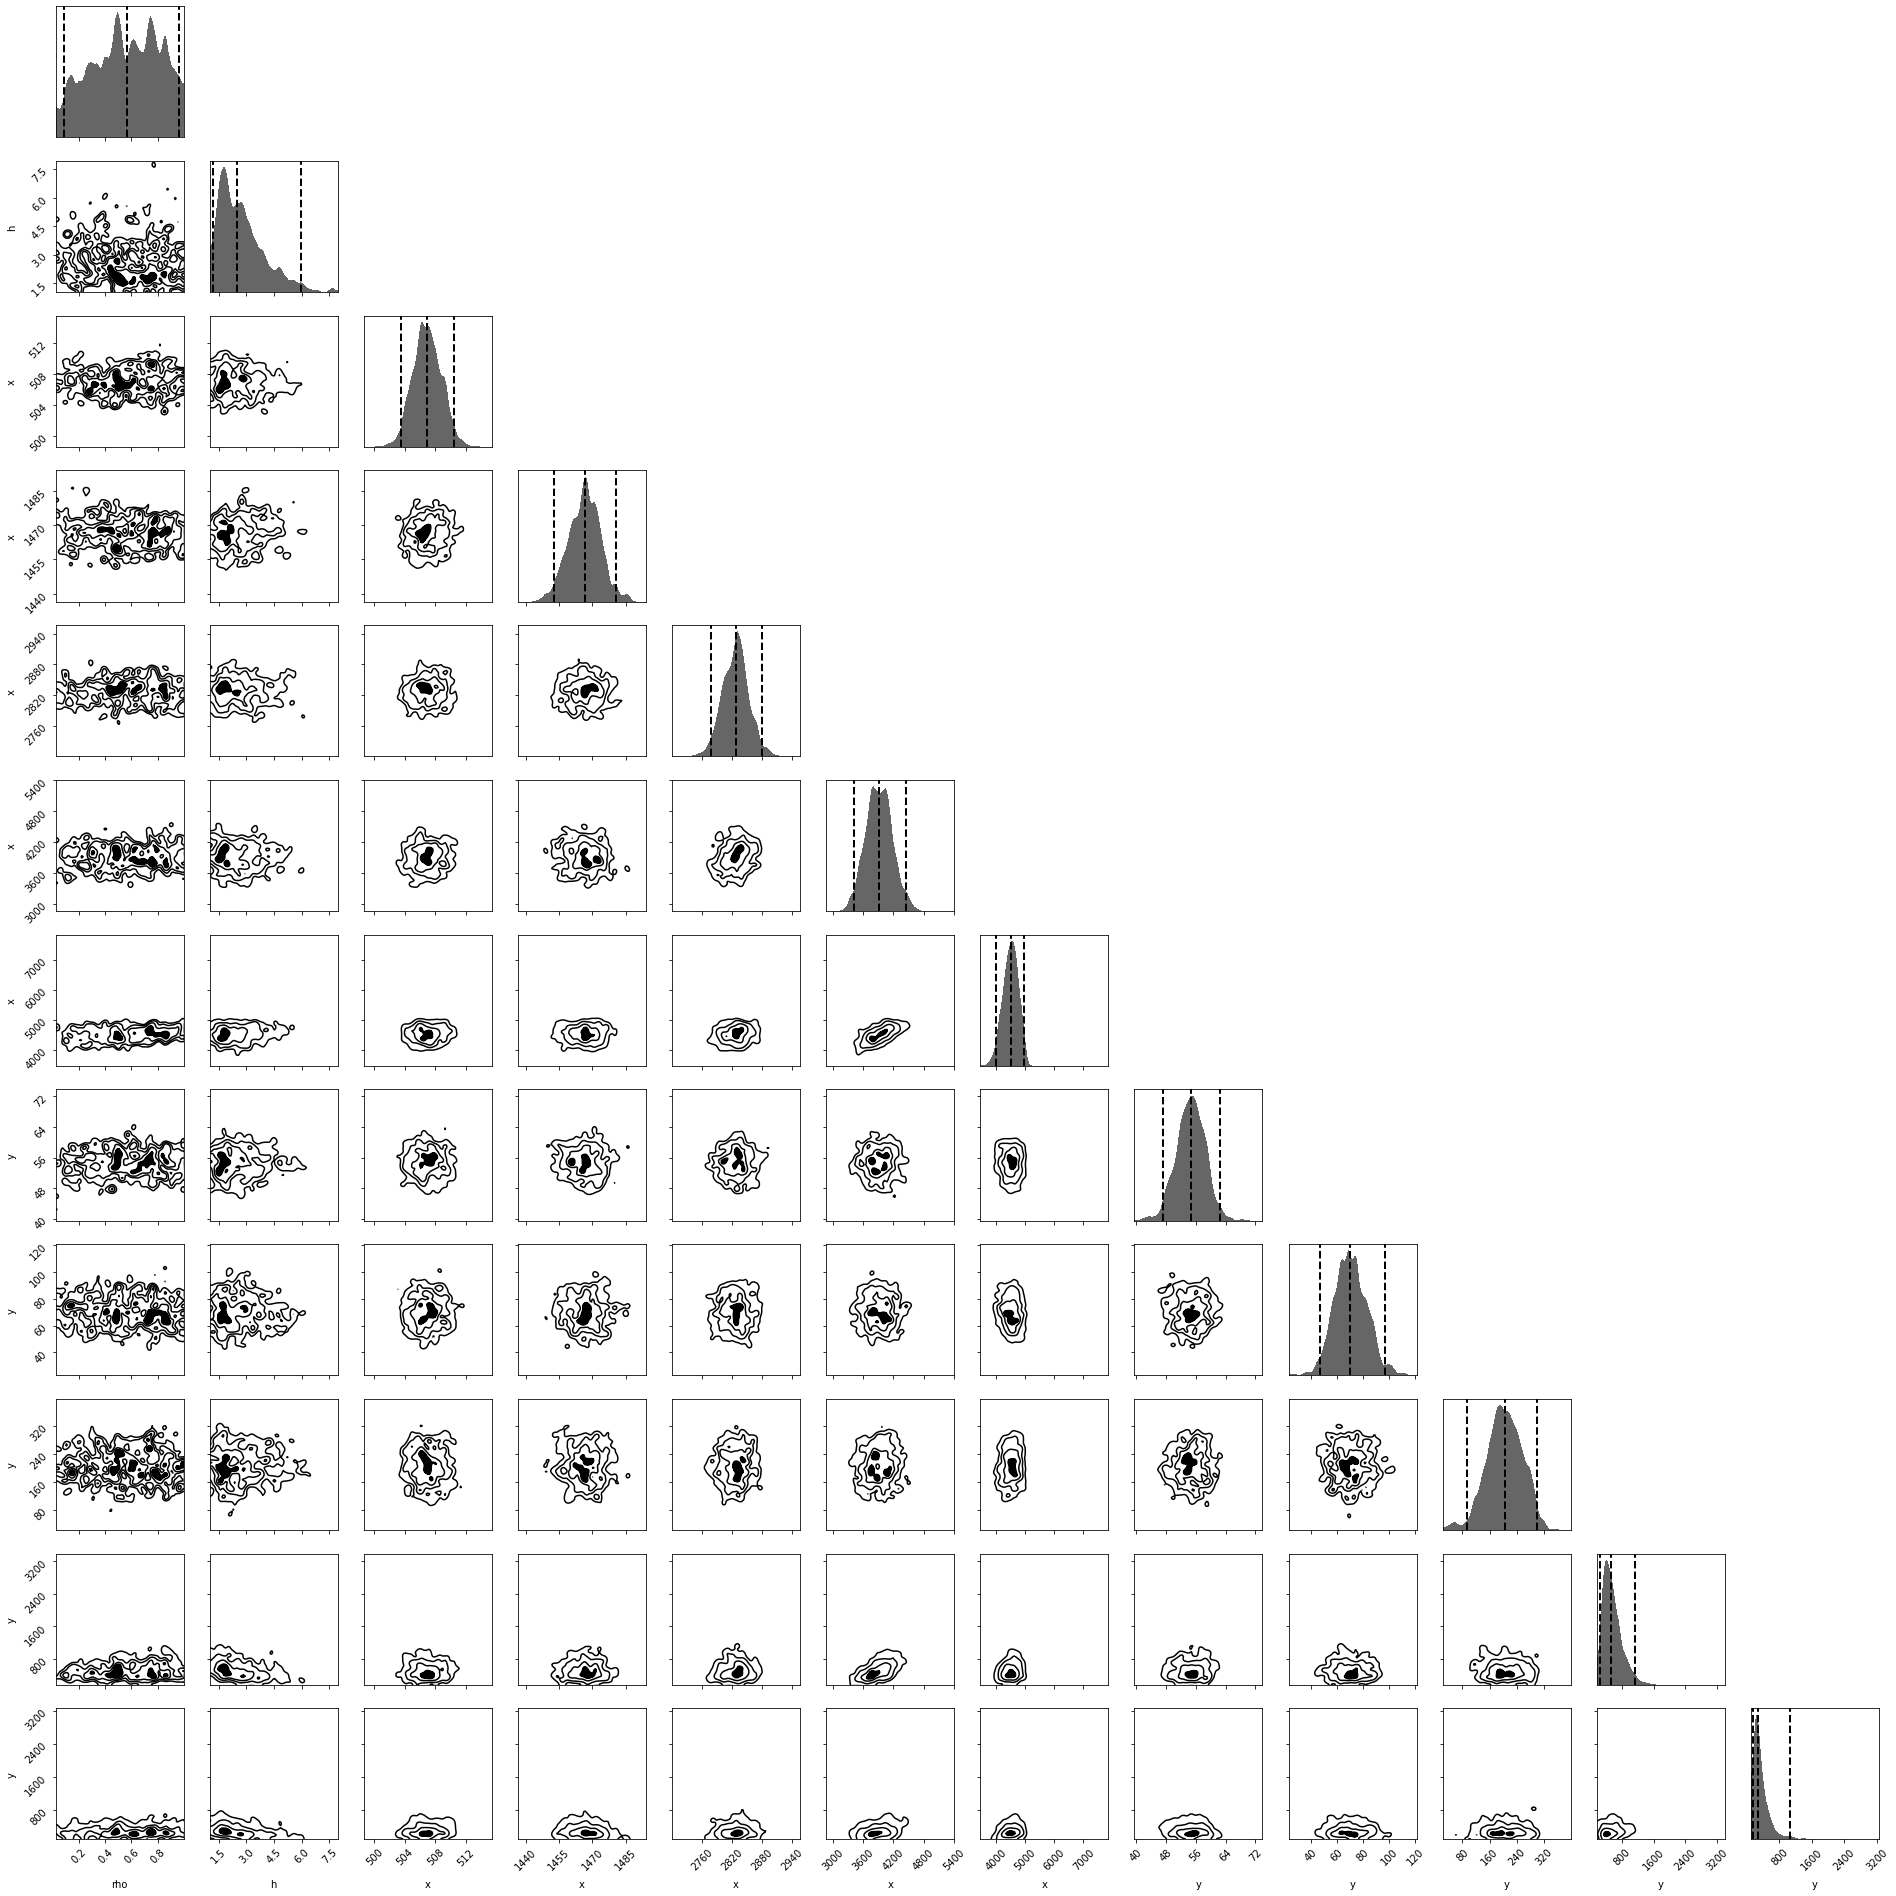

In [50]:
from lib import util

util.dyplot(results, ("rho", "h", *["x"]*K, *["y"]*K)); # (1.25, 1)

In [51]:
unpack(results.samples[-1,:])

(0.6464082458370378,
 4.620923577276173,
 array([ 506.27330002, 1468.49390192, 2843.1038451 , 4061.17849102,
        4665.7450076 ]),
 array([ 52.83771838,  70.73656589, 220.32821563, 342.31185831,
        173.17582658]))

[  1.13068011 -12.46073199  51.71936269]
[  7.53247727  30.40797031 -41.49378829]
[-1.86931989  1.53926801  7.71936269]
[  0.98610386   7.23020915 -73.30033061]
[ 0.13068011  1.53926801 19.71936269]
[-3.86432319 12.57934806 -5.07307135]


/home/marnix/WRK/thesis/py/vtr/spectrum.py:109: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
/home/marnix/WRK/thesis/py/vtr/spectrum.py:109: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
/home/marnix/WRK/thesis/py/vtr/spectrum.py:109: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


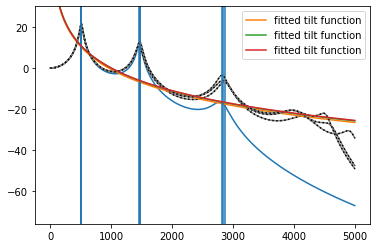

In [57]:
plot(sample['f'], sample['power'])

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F = np.array([2., 7., 29.]),
    sigma_B = np.array([4., 14., 58.])
):
    rho, h, x, y = unpack(params)
    
    poles = core.make_poles(y, x)
    power = allpole.transfer_function_power_dB(f/1000, poles)
    
    plot(f, power, "grey")
    
    try:
        F, B, context = spectrum.get_formants_from_spectrum(
            f, power, rho, h, return_full=True
        )
    except np.linalg.LinAlgError:
        return -np.inf
    
    plot(f, context['smoothed'], ":", color="black")
    
    for Fi in F: axvline(Fi)
    
    if len(F) != 3:
        return -np.inf
    
    print(F - F_true)
    print(B - B_true)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    
    tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)
    plot(f, interp(f), label="fitted tilt function")

    legend()
    
    return -(F_err + B_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())

ylim(None, 30);

In [53]:
from dgf import bijectors

post_samples = util.resample_equal(results, 100)[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*K + [(20., 5000.)]*K,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    post_samples, post_bounds, 123456789000
)

[Memory]2008.8s, 33.5min: Loading run_nested...


[ 505.55175815 1472.485628   2748.73715024 3483.73233206 4167.87951643]
[ 49.07214978 104.35260935 397.18554279 485.68304196 220.85295495]


(-13.035573694165194, -60.20599913279624)

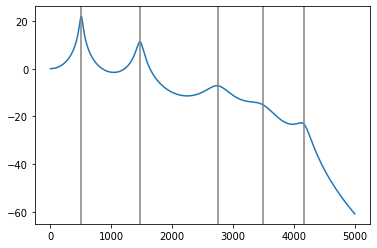

In [58]:
xy = b.forward(randn(2*K))
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = constants.spectrum_frequencies()
power = allpole.transfer_function_power_dB(f/1000, poles)

plot(f, power, label="our implementation")
for xi in x: axvline(xi, color="grey")

spectrum.fit_tilt(f, power), allpole.analytical_tilt(K)